In [17]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("audio-classification", model="dima806/english_accents_classification")

config.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at dima806/english_accents_classification were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at dima806/english_accents_classification and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.enc

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [18]:
file_path = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-05-02-01-02-12.wav"

pipe(file_path)

[{'score': 0.7715168595314026, 'label': 'us'},
 {'score': 0.21601532399654388, 'label': 'canada'},
 {'score': 0.007344060577452183, 'label': 'australia'},
 {'score': 0.0031188959255814552, 'label': 'england'},
 {'score': 0.0020048893056809902, 'label': 'indian'}]

In [20]:
!pip install evaluate

   ---------------------------------------- 0.0/84.1 kB ? eta -:--:--
   -------------------------------------- - 81.9/84.1 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/542.1 kB ? eta -:--:--
   ----------------- ---------------------- 235.5/542.1 kB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 542.1/542.1 kB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/64.9 kB ? eta -:--:--
   ---------------------------------------- 64.9/64.9 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/143.5 kB ? eta -:--:--
   ---------------------------------------- 143.5/143.5 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninsta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [1]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import gc  # Garbage collection module
import re  # Regular expressions for text processing
import numpy as np  # NumPy for numerical operations

# Suppress warnings
import warnings 
warnings.filterwarnings("ignore")

# Import tqdm for progress tracking
from tqdm import tqdm
tqdm.pandas()

# Import Path from pathlib for working with file paths
from pathlib import Path

# Import oversampling and undersampling methods from imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import class_weight calculation function from scikit-learn
from sklearn.utils.class_weight import compute_class_weight

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import itertools for working with iterators
import itertools

# Import various metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import PyTorch for deep learning
import torch

# Import the Hugging Face Transformers library
import transformers

# Print the version of the transformers library
print(transformers.__version__)

# Import torchaudio for audio processing with PyTorch
import torchaudio

# Print the version of torchaudio
print(torchaudio.__version__)

# Import a custom module named 'evaluate' for evaluation functions
import evaluate

# Import Audio for displaying audio clips in the notebook
from IPython.display import Audio

# Import various classes and modules from Hugging Face Transformers and Datasets
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes

4.41.2
2.3.0+cpu


In [2]:
# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 1

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Define the minimum number of records per label required for the dataset
MIN_RECORDS_PER_LABEL = 25

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.1

# Ensure that the product of MIN_RECORDS_PER_LABEL and TEST_SIZE is greater than 2
# This ensures a sufficient number of samples for testing

In [3]:
df0 = pd.read_csv('cv-valid-train.csv', usecols=['filename', 'accent'])
df1 = pd.read_csv('cv-valid-dev.csv', usecols=['filename', 'accent'])
df2 = pd.read_csv('cv-valid-test.csv', usecols=['filename', 'accent'])
dd = pd.concat([df0, df1, df2], axis=0)
dd = dd[~dd['accent'].isnull()].drop_duplicates()
print(dd.shape)
dd.sample(5).T

(67399, 2)


,63260,63100,35632,194036,125911
filename,cv-valid-train/sample-063260.mp3,cv-valid-train/sample-063100.mp3,cv-valid-train/sample-035632.mp3,cv-valid-train/sample-194036.mp3,cv-valid-train/sample-125911.mp3
accent,england,england,england,england,australia


In [4]:
dd['accent'].value_counts()

accent
us                32267
england           15564
indian             4670
australia          4482
canada             4084
scotland           1619
african            1220
newzealand         1191
ireland             981
philippines         340
wales               269
bermuda             203
malaysia            191
singapore           126
hongkong            104
southatlandtic       88
Name: count, dtype: int64

In [5]:
# Define a function to load bird sound data from a specified directory.
def load_data():
    # Initialize empty lists to store file paths and corresponding labels.
    file_list = []  # To store file paths
    full_list = []  # To store labels

    # Iterate through all the .mp3 files in the specified directory and its subdirectories.
    for file in tqdm(Path('common-voice/').glob('cv-valid-*/*/*.mp3')):
        # Extract the label from the file path by splitting the path and retrieving the second-to-last part.
        # The label is assumed to be the second-to-last part, separated by '/' and '_' characters.
        full_path = str(file)
        #file_name = '/'.join(str(file).split('/')[-2:])
        
        file_name = '\\'.join(str(file).split('\\')[-2:])
        # Replace backslashes with forward slashes
        file_name = file_name.replace('\\', '/')
        
        # Append the current file path to the file_list and its corresponding label to the label_list.
        file_list.append(file_name)
        full_list.append(full_path)

    # Create an empty DataFrame to organize the data.
    df = pd.DataFrame()

    # Create two columns in the DataFrame: 'file' to store file paths and 'label' to store labels.
    df['filename'] = file_list
    df['file'] = full_list

    # Return the DataFrame containing the file paths and labels.
    return df

In [6]:
df = load_data()
df.shape

3995it [00:00, 89953.86it/s]


(3995, 2)

In [7]:
df.head()

,filename,file
0,cv-valid-test/sample-000000.mp3,common-voice\cv-valid-test\cv-valid-test\sampl...
1,cv-valid-test/sample-000001.mp3,common-voice\cv-valid-test\cv-valid-test\sampl...
2,cv-valid-test/sample-000002.mp3,common-voice\cv-valid-test\cv-valid-test\sampl...
3,cv-valid-test/sample-000003.mp3,common-voice\cv-valid-test\cv-valid-test\sampl...
4,cv-valid-test/sample-000004.mp3,common-voice\cv-valid-test\cv-valid-test\sampl...


In [8]:
# merge dataframes to get the label
df = df.merge(dd, on='filename', how='inner')
df.rename(columns={'accent': 'label'}, inplace=True)

In [9]:
df.shape

(1338, 3)

In [10]:
from collections import Counter
labels = [lang for lang, _ in Counter(df['label']).most_common(35)] #selected all possible labels
print(labels)

['us', 'england', 'canada', 'australia', 'indian', 'scotland', 'african', 'ireland', 'newzealand', 'philippines', 'wales', 'hongkong', 'malaysia', 'bermuda', 'southatlandtic', 'singapore']


In [11]:
df = df[df['label'].isin(labels)]
print(df.shape)

(1338, 3)


In [12]:
# Retrieve unique values in the 'label' column of the DataFrame 'df'
unique_labels = df['label'].unique()
unique_labels

array(['us', 'england', 'scotland', 'african', 'indian', 'canada',
       'ireland', 'philippines', 'australia', 'newzealand', 'hongkong',
       'wales', 'southatlandtic', 'malaysia', 'singapore', 'bermuda'],
      dtype=object)

In [13]:
# random undersampling of a majority class
rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
y = df[['label']]
df = df.drop(['label'], axis=1)
df, y_resampled = rus.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
# # random oversampling of all minority classes
# y = df[['label']]
# df = df.drop(['label'], axis=1)
# ros = RandomOverSampler(random_state=83)
# df, y_resampled = ros.fit_resample(df, y)
# del y
# df['label'] = y_resampled
# del y_resampled

gc.collect()

print(df.shape)

(706, 3)


In [14]:
# Split files by chunks with == MAX_LENGTH size
def split_audio(file):
    try:
        # Load the audio file using torchaudio and get its sample rate.
        audio, rate = torchaudio.load(str(file))

        # Calculate the number of segments based on the MAX_LENGTH
        num_segments = (len(audio[0]) // MAX_LENGTH)  # Floor division to get segments

        # Create an empty list to store segmented audio data
        segmented_audio = []

        # Split the audio into segments
        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = min((i + 1) * MAX_LENGTH, len(audio[0]))
            segment = audio[0][start:end]

            # Create a transformation to resample the audio to a specified sample rate (RATE_HZ).
            transform = torchaudio.transforms.Resample(rate, RATE_HZ)
            segment = transform(segment).squeeze(0).numpy().reshape(-1)

            segmented_audio.append(segment)

        # Create a DataFrame from the segmented audio
        df_segments = pd.DataFrame({'audio': segmented_audio})

        return df_segments

    except Exception as e:
        # If an exception occurs (e.g., file not found), return nothing
        print(f"Error processing file: {e}")
        return None
    
df_list = []
for input_file, input_label in tqdm(zip(df['file'].values, df['label'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)
df = pd.concat(df_list, axis=0)
df.sample(5)

706it [00:36, 19.43it/s]


,audio,label
5,"[-0.018695373, -0.023779606, -0.025030367, -0....",african
6,"[-0.02613479, -0.040804274, -0.036213156, -0.0...",england
4,"[-0.1098164, -0.17445716, -0.13382559, -0.1111...",england
12,"[0.006414087, 0.0077638864, -0.004817637, -0.0...",indian
4,"[0.010138905, 0.02013308, 0.024344772, 0.02917...",scotland


In [15]:
# Selecting rows in the DataFrame where the 'audio' column is not null (contains non-missing values).
df = df[~df['audio'].isnull()]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8506 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   8506 non-null   object
 1   label   8506 non-null   object
dtypes: object(2)
memory usage: 199.4+ KB


In [17]:
# Removing the 'file' column from the DataFrame 'df'
if 'file' in df.columns:
    df = df.drop(['file'], axis=1)

In [18]:
# Identify the unique classes in the training data.
classes = np.unique(df[['label']])

print(classes)

# Calculate class weights using the 'balanced' option, which automatically adjusts for class imbalance.
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

['african' 'australia' 'bermuda' 'canada' 'england' 'hongkong' 'indian'
 'ireland' 'malaysia' 'newzealand' 'philippines' 'scotland' 'singapore'
 'southatlandtic' 'us' 'wales']
{'african': 1.591691616766467, 'australia': 0.5258407517309595, 'bermuda': 11.311170212765957, 'canada': 0.3949665676077266, 'england': 0.14812621900250766, 'hongkong': 12.363372093023257, 'indian': 0.4755143112701252, 'ireland': 2.331688596491228, 'malaysia': 8.306640625, 'newzealand': 2.7403350515463916, 'philippines': 4.467436974789916, 'scotland': 1.7149193548387096, 'singapore': 44.302083333333336, 'southatlandtic': 31.272058823529413, 'us': 59.06944444444444, 'wales': 8.178846153846154}


In [19]:
# Create a dataset from the Pandas DataFrame 'df'
dataset = Dataset.from_pandas(df)

In [20]:
# Create a list of unique labels
labels_list = ['african', 'australia', 'bermuda', 'canada', 'england', 'hongkong', 'indian',
 'ireland', 'malaysia', 'newzealand', 'philippines', 'scotland', 'singapore',
 'southatlandtic', 'us', 'wales'] #sorted(list(df['label'].unique()))


In [21]:
# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'african', 1: 'australia', 2: 'bermuda', 3: 'canada', 4: 'england', 5: 'hongkong', 6: 'indian', 7: 'ireland', 8: 'malaysia', 9: 'newzealand', 10: 'philippines', 11: 'scotland', 12: 'singapore', 13: 'southatlandtic', 14: 'us', 15: 'wales'} 

Mapping of Labels to IDs: {'african': 0, 'australia': 1, 'bermuda': 2, 'canada': 3, 'england': 4, 'hongkong': 5, 'indian': 6, 'ireland': 7, 'malaysia': 8, 'newzealand': 9, 'philippines': 10, 'scotland': 11, 'singapore': 12, 'southatlandtic': 13, 'us': 14, 'wales': 15}


In [22]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=True, stratify_by_column="label")

Map:   0%|          | 0/8506 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8506 [00:00<?, ? examples/s]

In [28]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "dima806/english_accents_classification" #"facebook/wav2vec2-base-960h" 
feature_extractor=AutoFeatureExtractor.from_pretrained(model_str)
model=AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(labels),ignore_mismatched_sizes=True)
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of the model checkpoint at dima806/english_accents_classification were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at dima806/english_accents_classification and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.enc

94.572688


In [24]:
def preprocess_function(batch):    
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dataset['train'] = dataset['train'].map(preprocess_function, remove_columns="audio", batched=False)
gc.collect()
dataset['test'] = dataset['test'].map(preprocess_function, remove_columns="audio", batched=False)
gc.collect()

Map:   0%|          | 0/7655 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

49

In [25]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')
    
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

In [111]:
!pip install transformers[torch]


   ---------------------------------------- 0.0/302.6 kB ? eta -:--:--
   --- ----------------------------------- 30.7/302.6 kB 660.6 kB/s eta 0:00:01
   ---------------- ----------------------- 122.9/302.6 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 302.6/302.6 kB 2.7 MB/s eta 0:00:00


In [113]:
!pip install accelerate -U

In [115]:
# Install the 'mlflow' library quietly (-q).
!pip install -q mlflow

In [29]:
from transformers import Trainer, TrainingArguments
batch_size=8
warmup_steps=50
weight_decay=0.02
num_train_epochs=1
model_name = "english_accents_classification"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-6, # 3e-5
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1, 
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1, # save fewer checkpoints to limit used space
    #report_to="mlflow",  # log to mlflow
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    #tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
trainer.train()


Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,2.113600,2.329789,0.507474,0.425382


SyntaxError: 'return' outside function (1057819902.py, line 38)

In [30]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(dataset["test"])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 2.3297886848449707, 'test_roc_auc': 0.5074741237275245, 'test_accuracy': 0.42538190364277323, 'test_runtime': 78.5641, 'test_samples_per_second': 10.832, 'test_steps_per_second': 1.362}


Accuracy: 0.4254
F1 Score: 0.0565


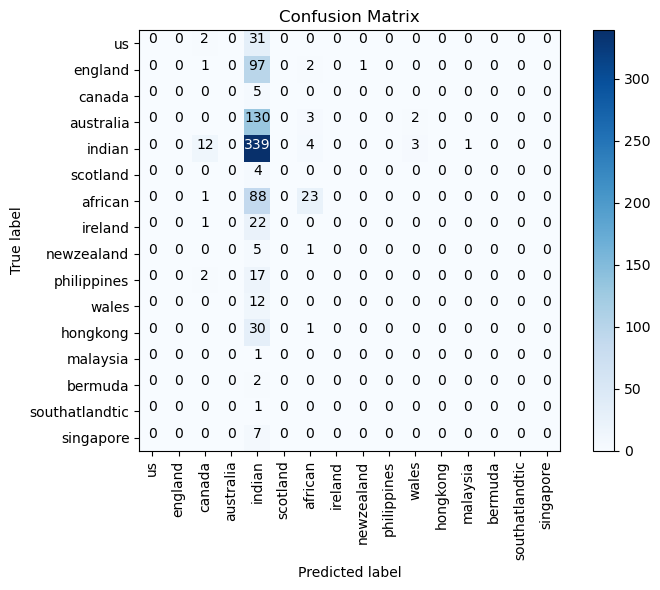


Classification report:

                precision    recall  f1-score   support

            us     0.0000    0.0000    0.0000        33
       england     0.0000    0.0000    0.0000       101
        canada     0.0000    0.0000    0.0000         5
     australia     0.0000    0.0000    0.0000       135
        indian     0.4286    0.9443    0.5896       359
      scotland     0.0000    0.0000    0.0000         4
       african     0.6765    0.2054    0.3151       112
       ireland     0.0000    0.0000    0.0000        23
    newzealand     0.0000    0.0000    0.0000         6
   philippines     0.0000    0.0000    0.0000        19
         wales     0.0000    0.0000    0.0000        12
      hongkong     0.0000    0.0000    0.0000        31
      malaysia     0.0000    0.0000    0.0000         1
       bermuda     0.0000    0.0000    0.0000         2
southatlandtic     0.0000    0.0000    0.0000         1
     singapore     0.0000    0.0000    0.0000         7

      accuracy       

In [31]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels, figsize=(8, 6), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

In [32]:
trainer.save_model()

In [38]:
# Load the saved model
model = AutoModelForAudioClassification.from_pretrained(model_name)

# Load the feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("dima806/english_accents_classification")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [44]:

audio,rate=torchaudio.load('odi_recordings/support_converted.wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)

target_sample_rate = feature_extractor.sampling_rate

# Preprocess the audio
inputs = feature_extractor(audio, sampling_rate=target_sample_rate, return_tensors="pt")

# Move inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Extract logits (raw predictions)
logits = outputs.logits

# Get predicted class
predicted_class_id = logits.argmax().item()
predicted_class_label = model.config.id2label[predicted_class_id]

# Print the predicted class
print(f"Predicted class ID: {predicted_class_id}")
print(f"Predicted class label: {predicted_class_label}")

Predicted class ID: 6
Predicted class label: indian
